Regression, Classification and Clustering Machine Learning Algorithms for Age of Empires II Definitive Edition Dataset


*   Trying to predict the Winner in Ranked Random Match in the Regression Problem
*   Winner prediction in Ranked Random Match in the Classification Problem
*   Players segmentation in Ranked Random Match in the Clustering Problem



In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, confusion_matrix
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/gdrive')
%cd /gdrive
root = '/gdrive/My Drive/AoE2_DE_Datasets/'

Mounted at /gdrive
/gdrive


# 1.Statistics of The Age of Empires II DE

## 1.1 Data

In [3]:
dataSetRanked = pd.read_csv(root + "rankedrm.csv", encoding = 'ISO-8859-1')
dataSetRanked.head()

,match_uuid,started,finished,map_type,steam_id.win,name.win,country.win,rating.win,rating_change.win,civ.win,color.win,steam_id.lose,name.lose,country.lose,rating.lose,rating_change.lose,civ.lose,color.lose,map_type.name,civ.lose.name,civ.win.name,matchup,duration
0,004b580b-dd9f-2841-a771-3693b41d7361,2021-03-01 00:00:14,2021-03-01 00:28:25,9,7.656120e+16,Uwiza,GB,1101.0,16.0,11,2.0,NaN,DrGustach,NaN,1107.0,-16.0,12,3.0,Arabia,Goths,Franks,Franks-Goths,00:28:11
1,a20d7ab9-e240-6f45-9f8e-a2f5d7641558,2021-03-01 00:00:24,2021-03-01 00:27:01,19,7.656120e+16,[DaRs] Chirris_,MX,1671.0,NaN,27,8.0,7.656120e+16,pH1,GT,1680.0,NaN,28,1.0,Islands,Saracens,Portuguese,Portuguese-Saracens,00:26:37
2,c1407700-1238-3d47-b5d3-a40cbc9a9722,2021-03-01 00:00:30,2021-03-01 00:42:56,9,7.656120e+16,Frigma,CL,1254.0,16.0,19,4.0,7.656120e+16,Sarlacc,GB,1268.0,-16.0,2,1.0,Arabia,Britons,Koreans,Britons-Koreans,00:42:26
3,1bdb9e60-81e6-514c-80fa-a2a56eed3e16,2021-03-01 00:00:26,2021-03-01 00:32:57,9,7.656120e+16,doctora Chinda Brandolino,AR,803.0,17.0,9,2.0,NaN,Matheuss Thiago,NaN,825.0,NaN,26,1.0,Arabia,Persians,Cumans,Cumans-Persians,00:32:31
4,12b09879-24b7-0049-a0b4-14dce9fe1950,2021-03-01 00:00:55,2021-03-01 00:44:07,16,NaN,PrecedentSolid4,NaN,661.0,33.0,11,2.0,7.656120e+16,cristobaltco,CL,601.0,-22.0,16,1.0,Fortress,Italians,Franks,Franks-Italians,00:43:12


In [4]:
dataSetMatchPlayers = pd.read_csv(root + "match_players.csv")
dataSetMatchPlayers.head()

,token,match,rating,color,civ,team,winner
0,rFWxLAdY6TF78xlo,axps4XstiBOmrDeG,1565.0,Red,Chinese,1,False
1,zsyvxRyzLh85YIba,axps4XstiBOmrDeG,1600.0,Blue,Goths,2,True
2,CHrJISNtjKDKM114,uQdosqwC7uiQ78ya,2145.0,Orange,Incas,1,False
3,X147inwVdQuaegxT,uQdosqwC7uiQ78ya,2124.0,Green,Tatars,2,True
4,kNckdaCe6pjKm6Au,uQdosqwC7uiQ78ya,2105.0,Red,Magyars,1,False


In [5]:
dataSetMatches = pd.read_csv(root + "matches.csv")
dataSetMatches.head()

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration
0,B2c2Ad6Uf6TVL5uk,2,False,RM_1v1,39515,1575.0,arabia,tiny,2,brazilsouth,0:23:30
1,eb8WdcbYlpeFLnoc,2,False,RM_TEAM,39515,2187.0,arabia,large,8,eastus,0:32:48
2,tphUBvZ8eZBmai0L,2,False,RM_TEAM,39515,2450.0,megarandom,large,8,brazilsouth,0:33:08
3,Kmhn0HZ8o8WwdXV9,1,False,RM_TEAM,39515,2387.0,arabia,large,8,ukwest,0:25:51
4,U198Wdc3kzJPBVqh,1,False,RM_1v1,37906,1095.0,acropolis,tiny,2,eastus,0:40:55


## 1.2 Statistics of Civilizations

In [6]:
dataSetMatchPlayers = pd.concat([dataSetMatchPlayers.iloc[:, 2], dataSetMatchPlayers.iloc[:, 4], dataSetMatchPlayers.iloc[:, 6]], axis = 1, join = "inner")
dataSetMatchPlayers = dataSetMatchPlayers.sample(n = int(len(dataSetMatchPlayers) * 0.001), random_state = 1)
dataSetMatchPlayers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9732 entries, 8381168 to 9082996
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  9213 non-null   float64
 1   civ     9732 non-null   object 
 2   winner  9732 non-null   bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 237.6+ KB


In [7]:
dataSetMatchPlayers["rating"] = dataSetMatchPlayers["rating"].replace(np.nan, dataSetMatchPlayers.median()["rating"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [8]:
dataSetMatchPlayers.isnull().sum() * 100 / dataSetMatchPlayers.shape[0]

rating    0.0
civ       0.0
winner    0.0
dtype: float64

In [9]:
dataSetMatchPlayers["winner"] = dataSetMatchPlayers["winner"].astype(int)

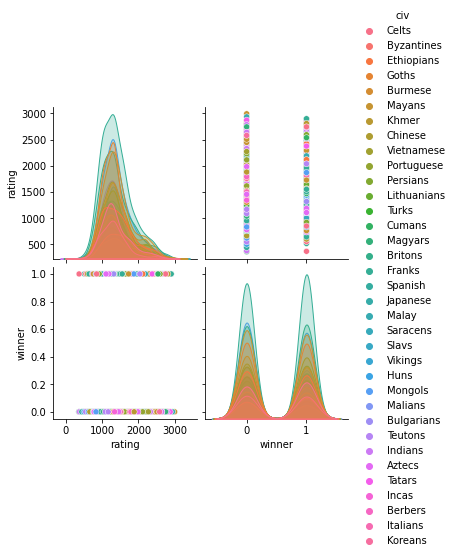

In [10]:
sns.pairplot(dataSetMatchPlayers, hue = "civ")

In [40]:
def pieDonut(dataFrame, column):
  fig, ax = plt.subplots(figsize=(10, 10), subplot_kw = dict(aspect = "equal"))

  data = dataFrame[column].value_counts()
  dataLabels = data.keys()

  wedges, texts = ax.pie(data, wedgeprops = dict(width = 0.5), startangle = -40)

  bbox_props = dict(boxstyle = "square,pad=0.3", fc = "w", ec = "k", lw = 0.72)
  kw = dict(arrowprops = dict(arrowstyle = "-"),
            bbox = bbox_props, zorder = 0, va = "center")

  for i, p in enumerate(wedges):
      if i < 10:
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(dataLabels[i], xy = (x, y), xytext = (1.35 * np.sign(x), 1.4 * y),
                    horizontalalignment = horizontalalignment, **kw)
      else:
        break
      
  ax.set_title(column)

  plt.show()

In [12]:
civMatches = dataSetMatchPlayers["civ"].groupby(dataSetMatchPlayers["civ"]).count().sort_values(ascending = False)
civMatches

civ
Franks         816
Britons        583
Mongols        570
Mayans         546
Goths          489
Persians       393
Khmer          386
Lithuanians    361
Aztecs         346
Ethiopians     320
Huns           309
Vikings        307
Teutons        299
Cumans         282
Spanish        279
Magyars        275
Celts          253
Vietnamese     236
Japanese       216
Chinese        205
Indians        188
Saracens       185
Bulgarians     179
Byzantines     179
Slavs          174
Turks          157
Incas          154
Burmese        153
Tatars         141
Berbers        141
Malay          134
Italians       130
Portuguese     126
Koreans        110
Malians        110
Name: civ, dtype: int64

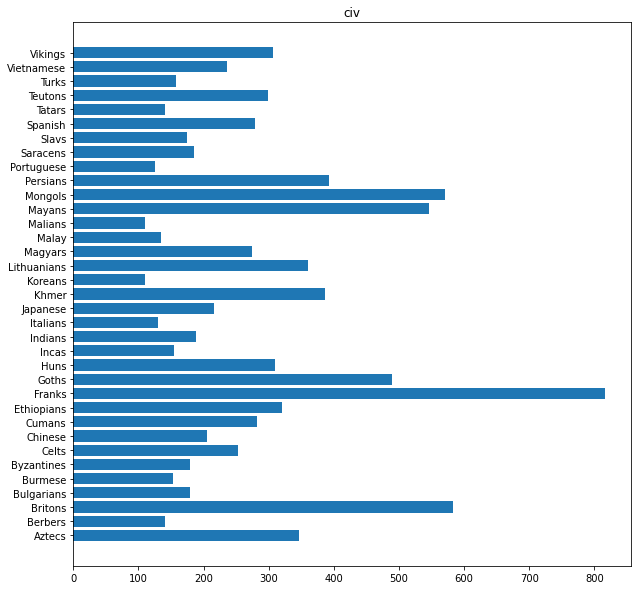

In [14]:
plt.figure(figsize=(10, 10))
plt.barh(dataSetMatchPlayers.groupby("civ")["civ"].count().index, dataSetMatchPlayers.groupby("civ")["civ"].count()) 
plt.title("civ")

plt.show()

In [13]:
print(dataSetMatchPlayers["civ"].groupby(dataSetMatchPlayers["civ"]).count().sort_values(ascending = False) / len(dataSetMatchPlayers["civ"]))

civ
Franks         0.083847
Britons        0.059905
Mongols        0.058570
Mayans         0.056104
Goths          0.050247
Persians       0.040382
Khmer          0.039663
Lithuanians    0.037094
Aztecs         0.035553
Ethiopians     0.032881
Huns           0.031751
Vikings        0.031545
Teutons        0.030723
Cumans         0.028977
Spanish        0.028668
Magyars        0.028257
Celts          0.025997
Vietnamese     0.024250
Japanese       0.022195
Chinese        0.021065
Indians        0.019318
Saracens       0.019009
Bulgarians     0.018393
Byzantines     0.018393
Slavs          0.017879
Turks          0.016132
Incas          0.015824
Burmese        0.015721
Tatars         0.014488
Berbers        0.014488
Malay          0.013769
Italians       0.013358
Portuguese     0.012947
Koreans        0.011303
Malians        0.011303
Name: civ, dtype: float64


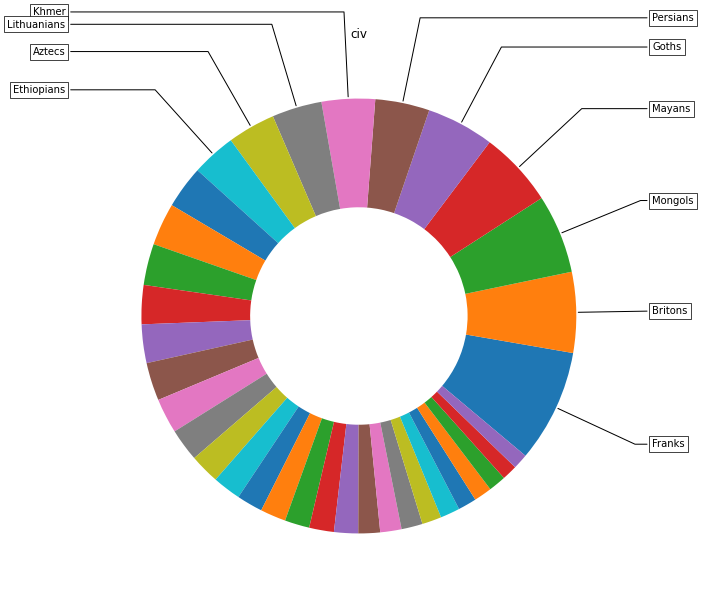

In [41]:
pieDonut(dataSetMatchPlayers, "civ")

In [42]:
civWins = dataSetMatchPlayers["winner"].loc[dataSetMatchPlayers['winner'] == 1].groupby(dataSetMatchPlayers["civ"]).count().sort_values(ascending = False)
civWinRate = civWins / civMatches
civWinRate.sort_values(ascending = False)

civ
Japanese       0.560185
Berbers        0.553191
Burmese        0.549020
Indians        0.537234
Malians        0.536364
Bulgarians     0.530726
Celts          0.529644
Persians       0.526718
Italians       0.523077
Huns           0.521036
Franks         0.515931
Vikings        0.511401
Spanish        0.505376
Britons        0.504288
Lithuanians    0.504155
Magyars        0.501818
Vietnamese     0.500000
Teutons        0.498328
Goths          0.496933
Chinese        0.492683
Byzantines     0.491620
Mayans         0.487179
Aztecs         0.485549
Ethiopians     0.478125
Slavs          0.477011
Mongols        0.471930
Tatars         0.468085
Cumans         0.460993
Saracens       0.454054
Portuguese     0.452381
Turks          0.452229
Khmer          0.450777
Incas          0.448052
Malay          0.447761
Koreans        0.354545
dtype: float64

## 1.3 Statistics of Maps

In [43]:
dataSetMatches = dataSetMatches.iloc[:, 3:10].sample(n = int(len(dataSetMatches) * 0.001), random_state = 1)
dataSetMatches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3153 entries, 1798583 to 187401
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ladder          3153 non-null   object 
 1   patch           3153 non-null   int64  
 2   average_rating  2971 non-null   float64
 3   map             3153 non-null   object 
 4   map_size        3153 non-null   object 
 5   num_players     3153 non-null   int64  
 6   server          3153 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 197.1+ KB


In [44]:
dataSetMatches.isnull().sum() * 100 / dataSetMatches.shape[0]

ladder            0.00000
patch             0.00000
average_rating    5.77228
map               0.00000
map_size          0.00000
num_players       0.00000
server            0.00000
dtype: float64

In [45]:
dataSetMatches["average_rating"] = dataSetMatches["average_rating"].replace(np.nan, dataSetMatches.median()["average_rating"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [46]:
numericalColumnsDSM = ["patch", "average_rating", "num_players"]
categoricalColumnsDSM = ["ladder", "map", "map_size", "server"]

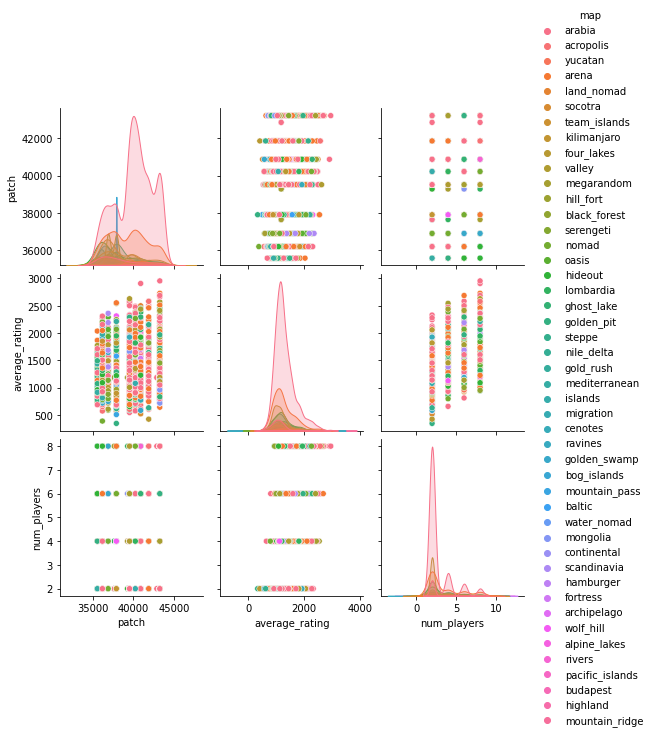

In [47]:
sns.pairplot(dataSetMatches, hue = "map")

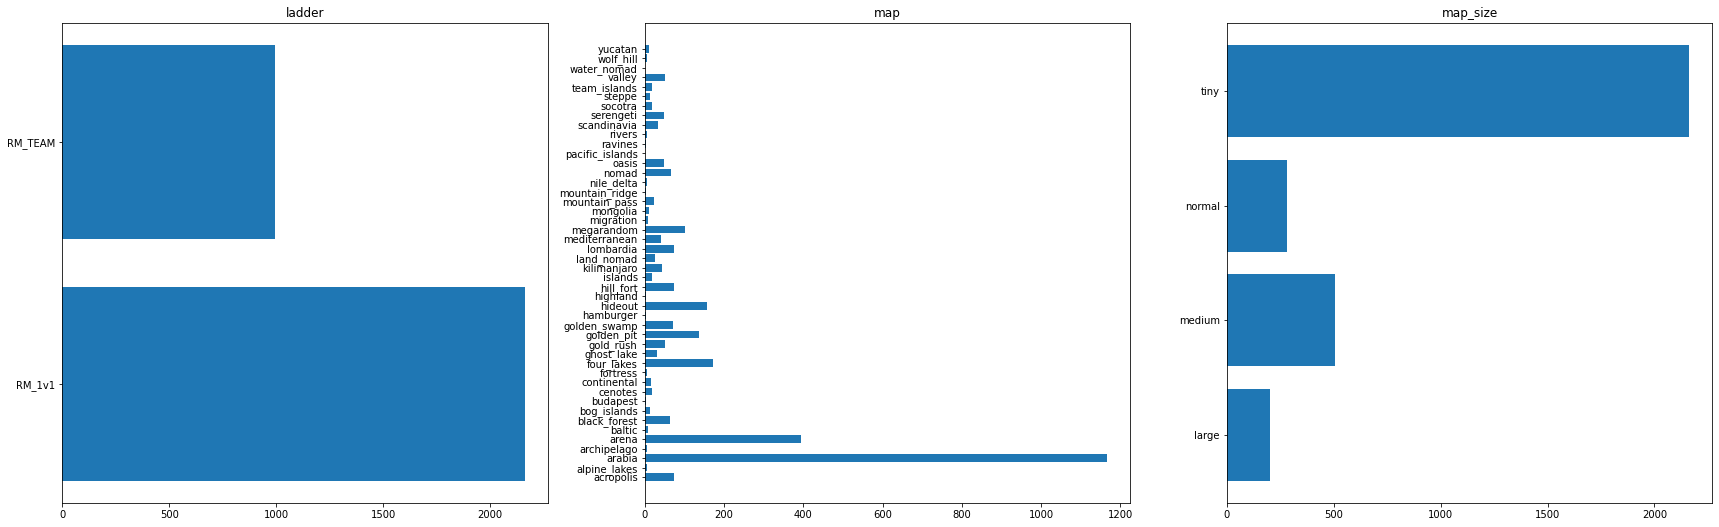

In [49]:
plt.figure(figsize=(40,30))
counter = 1
for i in categoricalColumnsDSM[:3]:
  plt.subplot(3, 4, counter)
  plt.barh(dataSetMatches.groupby(i)[i].count().index, dataSetMatches.groupby(i)[i].count()) 
  plt.title(i)

  counter += 1

In [50]:
print(dataSetMatches["map"].groupby(dataSetMatches["map"]).count().sort_values(ascending = False) / len(dataSetMatches["map"]))

map
arabia             0.369807
arena              0.124960
four_lakes         0.054551
hideout            0.049477
golden_pit         0.043451
megarandom         0.032033
hill_fort          0.023787
lombardia          0.023787
acropolis          0.023787
golden_swamp       0.022835
nomad              0.020932
black_forest       0.020615
gold_rush          0.016492
valley             0.015858
oasis              0.015224
serengeti          0.015224
kilimanjaro        0.013955
mediterranean      0.012686
scandinavia        0.010466
ghost_lake         0.010149
land_nomad         0.007929
mountain_pass      0.007612
cenotes            0.006026
team_islands       0.006026
socotra            0.006026
islands            0.005709
continental        0.004757
steppe             0.004440
bog_islands        0.004123
mongolia           0.003489
yucatan            0.003172
migration          0.002854
baltic             0.002854
fortress           0.002220
nile_delta         0.001903
wolf_hill       

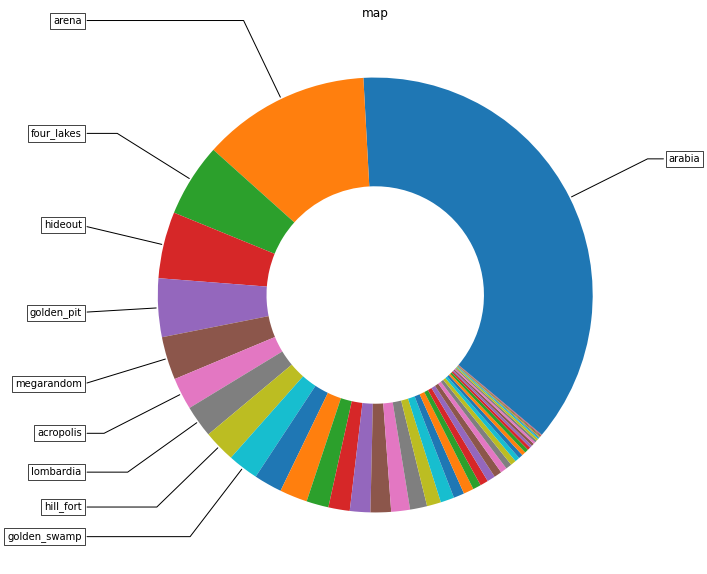

In [51]:
pieDonut(dataSetMatches, "map")

In [52]:
for i in dataSetMatches["map_size"].unique():
  print("-" * 10 + i + "-" * 10)
  mapsWithSize = dataSetMatches["map_size"].loc[dataSetMatches["map_size"] == i].groupby(dataSetMatches["map"]).count().sort_values(ascending = False)
  print(mapsWithSize)

----------tiny----------
map
arabia           908
arena            247
four_lakes       165
golden_pit       117
hideout          103
acropolis         74
megarandom        57
golden_swamp      49
serengeti         45
kilimanjaro       44
hill_fort         43
gold_rush         39
mediterranean     34
valley            33
nomad             29
mountain_pass     24
ghost_lake        20
islands           17
continental       15
bog_islands       13
socotra           12
black_forest      12
cenotes           12
baltic             8
migration          7
steppe             7
nile_delta         6
archipelago        5
alpine_lakes       4
mongolia           3
fortress           3
hamburger          2
ravines            2
team_islands       2
water_nomad        1
Name: map_size, dtype: int64
----------large----------
map
arabia           45
arena            40
lombardia        15
black_forest     12
oasis            12
hideout          11
megarandom       10
hill_fort         8
golden_swamp     

## 1.4 Statistics of Servers

In [53]:
servers = dataSetMatches["server"].groupby(dataSetMatches["server"]).count().sort_values(ascending = False)
servers

server
ukwest                1437
eastus                 581
brazilsouth            490
westindia              175
southeastasia          159
westus2                119
australiasoutheast      88
westeurope              65
koreacentral            39
Name: server, dtype: int64

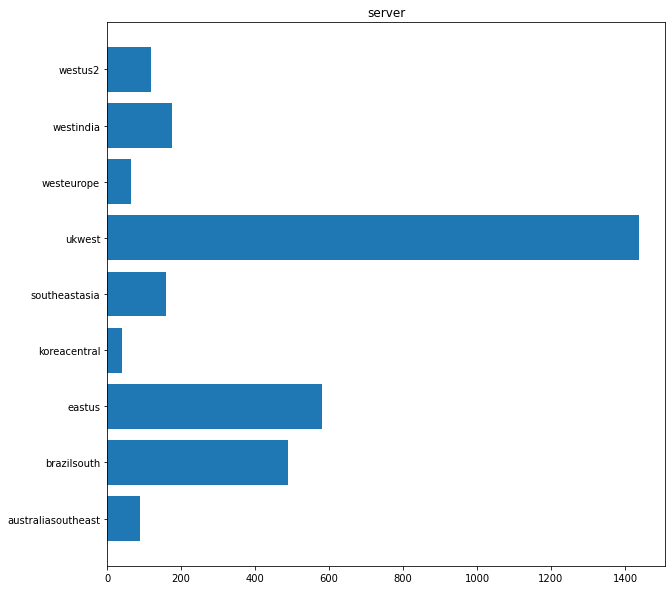

In [54]:
plt.figure(figsize=(10, 10))
plt.barh(dataSetMatches.groupby("server")["server"].count().index, dataSetMatches.groupby("server")["server"].count()) 
plt.title("server")

plt.show()

In [55]:
print(servers / len(dataSetMatches["server"]))

server
ukwest                0.455756
eastus                0.184269
brazilsouth           0.155408
westindia             0.055503
southeastasia         0.050428
westus2               0.037742
australiasoutheast    0.027910
westeurope            0.020615
koreacentral          0.012369
Name: server, dtype: float64


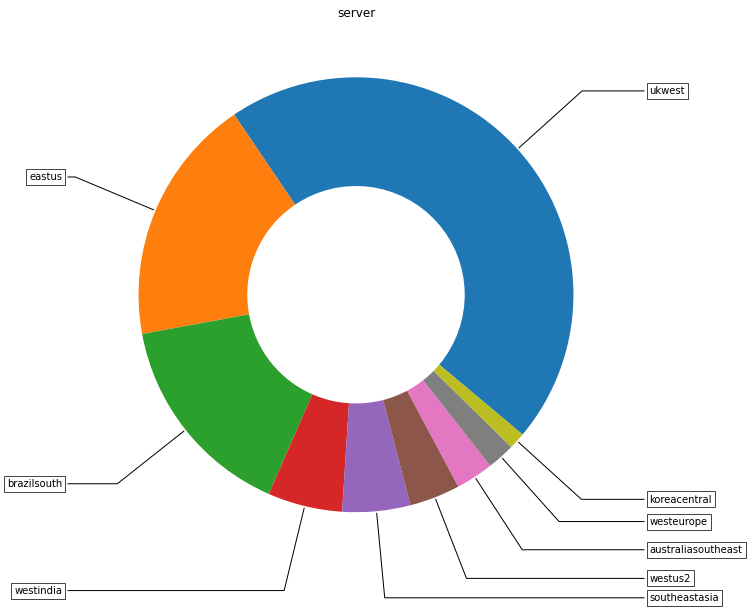

In [57]:
pieDonut(dataSetMatches, "server")

# 2.Data Preprocessing for Ranked Random Matches Dataset

## 2.1 Data Cleaning

In [ ]:
dataSetRanked = pd.concat([dataSetRanked.iloc[:, 7], dataSetRanked.iloc[:, 14] ,dataSetRanked.iloc[:, 18:21] ,dataSetRanked.iloc[:, 22]], axis = 1, join = "inner")
dataSetRanked = dataSetRanked.sample(n = int(len(dataSetRanked) * 0.01), random_state = 1)
dataSetRanked.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056 entries, 94532 to 8913
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rating.win     1026 non-null   float64
 1   rating.lose    972 non-null    float64
 2   map_type.name  1056 non-null   object 
 3   civ.lose.name  1056 non-null   object 
 4   civ.win.name   1056 non-null   object 
 5   duration       1056 non-null   object 
dtypes: float64(2), object(4)
memory usage: 57.8+ KB


In [ ]:
dataSetRanked

,rating.win,rating.lose,map_type.name,civ.lose.name,civ.win.name,duration
94532,971.0,955.0,MegaRandom,Celts,Magyars,00:38:53
13268,808.0,756.0,Arabia,Sicilians,Khmer,00:19:12
18689,892.0,896.0,Fortress,Incas,Ethiopians,00:27:51
102302,1126.0,1101.0,Arabia,Franks,Franks,00:15:30
41530,1777.0,1809.0,Arabia,Incas,Turks,00:09:04
...,...,...,...,...,...,...
51433,1730.0,1712.0,Arabia,Khmer,Aztecs,00:20:55
85729,844.0,852.0,Arabia,Khmer,Lithuanians,00:25:19
77440,837.0,821.0,Arabia,Huns,Franks,00:23:33
53799,1253.0,1227.0,Arabia,Lithuanians,Huns,00:33:10


### 2.1.1 Missing Values

In [ ]:
dataSetRanked["rating.win"] = dataSetRanked["rating.win"].replace(np.nan, dataSetRanked.median()["rating.win"])
dataSetRanked["rating.lose"] = dataSetRanked["rating.lose"].replace(np.nan, dataSetRanked.median()["rating.lose"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
import time, datetime
def convertTime(t):
  h, m, s = map(int, t.split(':'))
  return (h * 60 + m) * 60 + s

dataSetRanked["duration"] = dataSetRanked["duration"].apply(convertTime)

In [ ]:
winners = pd.concat([dataSetRanked.iloc[:, 0], dataSetRanked.iloc[:, 2], dataSetRanked.iloc[:, 4:]], axis = 1)
winners = winners.rename({"rating.win" : "rating", "map_type.name" : "map", "civ.win.name" : "civ"}, axis = 1)
winners["winner"] = pd.Series([1 for i in range(len(winners.index))])
winners["winner"] = winners["winner"].replace(np.nan, 1)

In [ ]:
losers = pd.concat([dataSetRanked.iloc[:, 1], dataSetRanked.iloc[:, 2:4], dataSetRanked.iloc[:, 5]], axis = 1)
losers = losers.rename({"rating.lose" : "rating", "map_type.name" : "map", "civ.lose.name" : "civ"}, axis = 1)
losers["winner"] = pd.Series([1 for i in range(len(losers.index))])
losers["winner"] = losers["winner"].replace(np.nan, 0)

In [ ]:
#test = dataSetRanked['rating.win'].append(dataSetRanked['rating.lose']).reset_index(drop = True)

In [ ]:
trainSet = pd.concat([winners, losers])
trainSet

,rating,map,civ,duration,winner
94532,971.0,MegaRandom,Magyars,2333,1.0
13268,808.0,Arabia,Khmer,1152,1.0
18689,892.0,Fortress,Ethiopians,1671,1.0
102302,1126.0,Arabia,Franks,930,1.0
41530,1777.0,Arabia,Turks,544,1.0
...,...,...,...,...,...
51433,1712.0,Arabia,Khmer,1255,0.0
85729,852.0,Arabia,Khmer,1519,0.0
77440,821.0,Arabia,Huns,1413,0.0
53799,1227.0,Arabia,Lithuanians,1990,0.0


In [ ]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2112 entries, 94532 to 8913
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rating    2112 non-null   float64
 1   map       2112 non-null   object 
 2   civ       2112 non-null   object 
 3   duration  2112 non-null   int64  
 4   winner    2112 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 99.0+ KB


In [ ]:
trainSet.nunique()

rating      918
map          12
civ          37
duration    838
winner        2
dtype: int64

In [ ]:
numericalColumns = ["rating", "duration"]
categoricalColumns = ["map", "civ", "winner"]

### 2.1.2 Outlier

#### 2.1.2.1 Outlier (Boxplot)

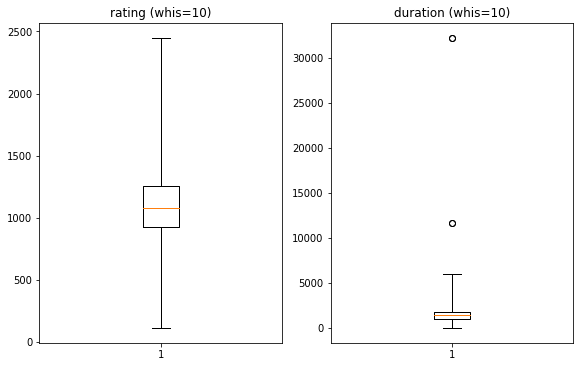

In [ ]:
plt.figure(figsize=(20,20))
counter = 1
for i in numericalColumns:
  plt.subplot(3,4,counter)
  plt.boxplot(trainSet[i], whis=10)
  plt.title(f"{i} (whis=10)")

  counter += 1

plt.show()

#### 2.1.2.2 Outlier (Winsorize)

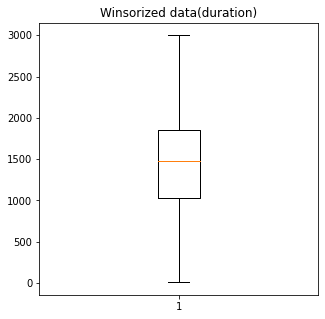

In [ ]:
trainSet["duration"] = winsorize(trainSet["duration"], (0, 0.02))

plt.figure(figsize = (5, 5))
plt.title("Winsorized data(duration)")
plt.boxplot(trainSet["duration"], whis = 10)

plt.show()

## 2.2 Data Exploration

### 2.2.1 Continous Variable Visualization

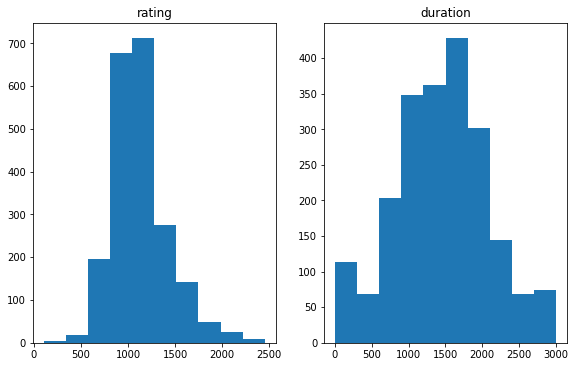

In [ ]:
plt.figure(figsize=(20,20))
counter = 1
for i in numericalColumns:
  plt.subplot(3,4,counter)
  plt.hist(trainSet[i])
  plt.title(i)
  
  counter += 1

plt.show()

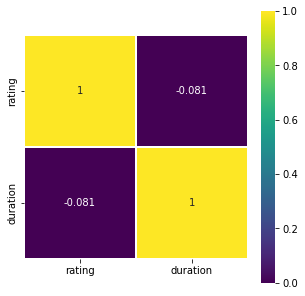

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(trainSet[["rating", "duration"]].corr(), square=True, annot=True, linewidths=.5, vmin=0, vmax=1, cmap='viridis')

### 2.2.2 Categorical Variable Visualization

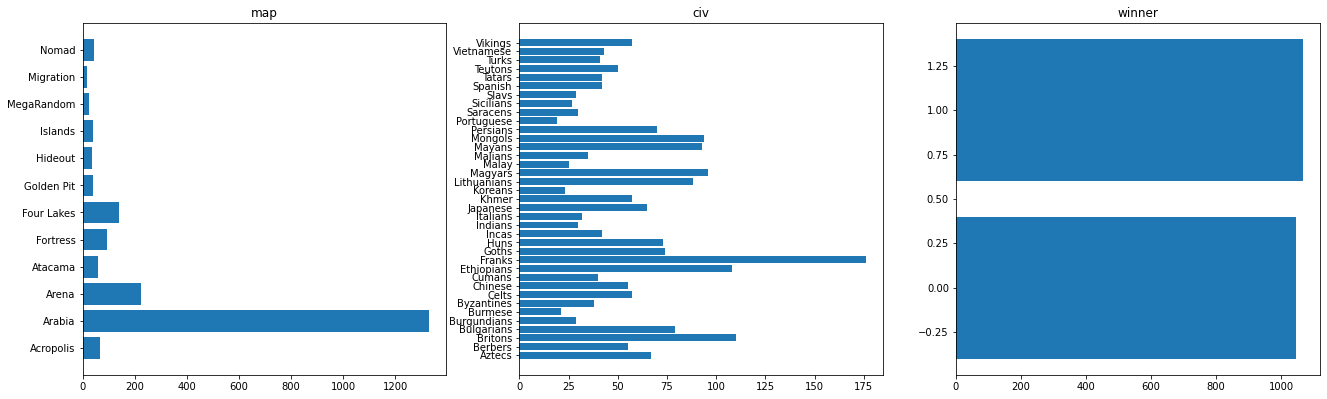

In [ ]:
plt.figure(figsize=(30,22))
counter = 1
for i in categoricalColumns:
  plt.subplot(3, 4, counter)
  plt.barh(trainSet.groupby(i)[i].count().index, trainSet.groupby(i)[i].count()) 
  plt.title(i)

  counter += 1

plt.show()

# 3.Feature Engineering

In [ ]:
featuresDF = pd.get_dummies(trainSet, columns = categoricalColumns)

## 3.1 Standard Scaling

In [ ]:
scaler = StandardScaler()
for i in numericalColumns:
  featuresDF[i] = scaler.fit_transform(featuresDF[[i]])

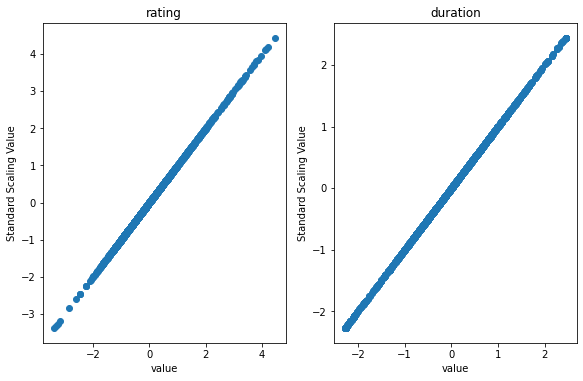

In [ ]:
plt.figure(figsize=(20,20))
counter = 1
for i in numericalColumns:
    plt.subplot(3, 4, counter)
    plt.scatter(featuresDF[i], featuresDF[i])
    plt.title(i)
    plt.xlabel("value")
    plt.ylabel("Standard Scaling Value")

    counter += 1

plt.show()

In [ ]:
featuresDF.shape

(2112, 54)

## 3.2 Dimension Reduction

In [ ]:
corrMatrix = featuresDF.corr().abs()
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
toDrop = [column for column in upper.columns if any(upper[column] > 0.90)]
featuresDF =  featuresDF.drop(toDrop, axis=1)
featuresDF.shape

(2112, 53)

In [ ]:
featuresDF

,rating,duration,cluster,map_Acropolis,map_Arabia,map_Arena,map_Atacama,map_Fortress,map_Four Lakes,map_Golden Pit,map_Hideout,map_Islands,map_MegaRandom,map_Migration,map_Nomad,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Celts,civ_Chinese,civ_Cumans,civ_Ethiopians,civ_Franks,civ_Goths,civ_Huns,civ_Incas,civ_Indians,civ_Italians,civ_Japanese,civ_Khmer,civ_Koreans,civ_Lithuanians,civ_Magyars,civ_Malay,civ_Malians,civ_Mayans,civ_Mongols,civ_Persians,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings,winner_0.0
94532,-0.502537,1.395312,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13268,-1.047883,-0.466384,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18689,-0.766846,0.351754,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102302,0.016044,-0.816339,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41530,2.194084,-1.424818,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51433,1.976614,-0.304017,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85729,-0.900673,0.112145,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
77440,-1.004389,-0.054951,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
53799,0.353958,0.854616,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# 4.Regression Problem

## 4.1 Train-Test Split

In [ ]:
Y = featuresDF["winner_0.0"]
X = featuresDF.drop("winner_0.0", axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.2, random_state = 42)

## 4.2 Grid Search

In [ ]:
#Decision Tree
DTC_Regressor = DecisionTreeRegressor()
DTC_params= {"criterion":["squared_error"], "min_samples_split": [2, 3, 4], "min_samples_leaf": [1, 2, 4], "max_depth": [None, 3, 5]}
DTC_grid_cv = GridSearchCV(DTC_Regressor, param_grid=DTC_params, cv=4)
DTC_grid_cv.fit(X_train, Y_train)

#Random Forest
rf_Regressor = RandomForestRegressor()
rf_params= {"n_estimators":[70, 100, 130], "min_samples_leaf": [1, 2, 4], "min_samples_split": [2, 5, 10], "n_jobs": [-1]}
rf_grid_cv = GridSearchCV(rf_Regressor, param_grid=rf_params, cv=4)
rf_grid_cv.fit(X_train, Y_train)

#KNN
KNN_Regressor = KNeighborsRegressor()
KNN_params= {"n_neighbors":[3,4,5,6,7], "n_jobs": [-1], "weights":["uniform", "distance"]}
KNN_grid_cv = GridSearchCV(KNN_Regressor, param_grid=KNN_params, cv=4)
KNN_grid_cv.fit(X_train, Y_train)

GridSearchCV(cv=4, estimator=KNeighborsRegressor(),
             param_grid={'n_jobs': [-1], 'n_neighbors': [3, 4, 5, 6, 7],
                         'weights': ['uniform', 'distance']})

In [ ]:
print("-" * 60 + "Decision Tree" + "-" * 60)
print("Best parameters     : ", DTC_grid_cv.best_params_)
print("Best scores         : ", DTC_grid_cv.best_score_)

print("-" * 60 + "Random Forest" + "-" * 60)
print("Best parameters     : ", rf_grid_cv.best_params_)
print("Best scores         : ", rf_grid_cv.best_score_)

print("-" * 60 + "KNN" + "-" * 70)
print("Best parameters     : ", KNN_grid_cv.best_params_)
print("Best scores         : ", KNN_grid_cv.best_score_)

------------------------------------------------------------Decision Tree------------------------------------------------------------
Best parameters     :  {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best scores         :  -0.07748270638447752
------------------------------------------------------------Random Forest------------------------------------------------------------
Best parameters     :  {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}
Best scores         :  -0.12366443388840581
------------------------------------------------------------KNN----------------------------------------------------------------------
Best parameters     :  {'n_jobs': -1, 'n_neighbors': 7, 'weights': 'uniform'}
Best scores         :  -0.14583244353330604


We can not apply to regression models in this case.

# 5.Classification Problem

## 5.1 Model Training

### 5.1.1 Grid search

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#Decision Tree
DTC_Classifier = DecisionTreeClassifier()
DTC_params= {"criterion":["entropy"], "min_samples_split": [2, 3, 4], "min_samples_leaf": [1, 2, 4]}
DTC_grid_cv = GridSearchCV(DTC_Classifier, param_grid=DTC_params, cv=4)
DTC_grid_cv.fit(X_train, Y_train)

#XGBOOST
xgb_Classifier = XGBClassifier()
xgb_params= {"min_child_weight": [1, 5, 10], "max_depth": [3,4], "colsample_bytree": [0.6, 1.0], "learning_rate":[0.1, 0.3], "n_jobs": [-1]}
xgb_grid_cv = GridSearchCV(xgb_Classifier, param_grid=xgb_params, cv=4)
xgb_grid_cv.fit(X_train, Y_train)

#Random Forest
rf_Classifier = RandomForestClassifier()
rf_params= {"n_estimators":[90, 100, 110], "min_samples_leaf": [1, 2, 4], "min_samples_split": [2, 5, 10], "n_jobs": [-1]}
rf_grid_cv = GridSearchCV(rf_Classifier, param_grid=rf_params, cv=4)
rf_grid_cv.fit(X_train, Y_train)

#KNN
KNN_Classifier = KNeighborsClassifier()
KNN_params= {"n_neighbors":[3,4,5,6,7], "n_jobs": [-1]}
KNN_grid_cv = GridSearchCV(KNN_Classifier, param_grid=KNN_params, cv=4)
KNN_grid_cv.fit(X_train, Y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': [3, 4, 5, 6, 7]})

In [ ]:
print("-" * 60 + "Decision Tree" + "-" * 60)
print("Best parameters     : ", DTC_grid_cv.best_params_)
print("Best scores         : ", DTC_grid_cv.best_score_)

print("-" * 60 + "XGBOOST" + "-" * 66)
print("Best parameters     : ", xgb_grid_cv.best_params_)
print("Best scores         : ", xgb_grid_cv.best_score_)

print("-" * 60 + "Random Forest" + "-" * 60)
print("Best parameters     : ", rf_grid_cv.best_params_)
print("Best scores         : ", rf_grid_cv.best_score_)

print("-" * 60 + "KNN" + "-" * 70)
print("Best parameters     : ", KNN_grid_cv.best_params_)
print("Best scores         : ", KNN_grid_cv.best_score_)

------------------------------------------------------------Decision Tree------------------------------------------------------------
Best parameters     :  {'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 4}
Best scores         :  0.5143306379155436
------------------------------------------------------------XGBOOST------------------------------------------------------------------
Best parameters     :  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_jobs': -1}
Best scores         :  0.561769991015274
------------------------------------------------------------Random Forest------------------------------------------------------------
Best parameters     :  {'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 110, 'n_jobs': -1}
Best scores         :  0.5736522911051213
------------------------------------------------------------KNN----------------------------------------------------------------------
Best parameter

### 5.1.2 Training

In [ ]:
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

DTC_Classifier = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 4, min_samples_split = 4)
DTC_Classifier.fit(X_train, Y_train)

xgb = XGBClassifier(colsample_bytree = 1.0, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, n_jobs = -1)
xgb.fit(X_train, Y_train)

rf = RandomForestClassifier(min_samples_leaf = 4, min_samples_split = 5, n_estimators = 110, n_jobs = -1)
rf.fit(X_train,Y_train)

KNN_Classifier = KNeighborsClassifier(n_jobs = -1, n_neighbors = 7)
KNN_Classifier.fit(X_train, Y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7)

## 5.2 Model Evaluating

In [ ]:
models = []
models.append(('Naive Bayes Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('XGBOOST', xgb))
models.append(('Random Forest', rf))
models.append(('KNN_Classifier', KNN_Classifier))

In [ ]:
from sklearn import metrics
for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv = 4)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))

    print(f"----------------------------- {i} Model Evaluation -----------------------------")
    print(f"\nCross Validation Mean Score:\n {scores.mean()}\n")
    print(f"\n Model Accuracy:\n {accuracy}\n")
    print(f"\n Classification report:\n\n {classification}") 

----------------------------- Naive Bayes Classifier Model Evaluation -----------------------------

Cross Validation Mean Score:
 0.5308625336927224


 Model Accuracy:
 0.6327014218009479


 Classification report:

               precision    recall  f1-score   support

           0       0.61      0.49      0.54       189
           1       0.64      0.75      0.69       233

    accuracy                           0.63       422
   macro avg       0.63      0.62      0.62       422
weighted avg       0.63      0.63      0.63       422

----------------------------- Decision Tree Classifier Model Evaluation -----------------------------

Cross Validation Mean Score:
 0.5191374663072776


 Model Accuracy:
 0.8009478672985783


 Classification report:

               precision    recall  f1-score   support

           0       0.74      0.86      0.79       189
           1       0.87      0.76      0.81       233

    accuracy                           0.80       422
   macro avg       

## 5.3 Model Test Accuracy

In [ ]:
def confusionMatrix(i, cm):
  fig, ax = plt.subplots(figsize = (5, 5))
  sns.heatmap(cm, linewidths = 1, annot = True, ax = ax, fmt = 'g')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title(f'{i} Confusion Matrix')

----------------------------- Naive Bayes Classifier Model Test Results -----------------------------

 Model Accuracy:
 0.4940828402366864


 Classification report:

               precision    recall  f1-score   support

           0       0.52      0.37      0.43       877
           1       0.48      0.63      0.54       813

    accuracy                           0.49      1690
   macro avg       0.50      0.50      0.49      1690
weighted avg       0.50      0.49      0.49      1690

----------------------------- Decision Tree Classifier Model Test Results -----------------------------

 Model Accuracy:
 0.4834319526627219


 Classification report:

               precision    recall  f1-score   support

           0       0.50      0.49      0.50       877
           1       0.46      0.47      0.47       813

    accuracy                           0.48      1690
   macro avg       0.48      0.48      0.48      1690
weighted avg       0.48      0.48      0.48      1690

--------

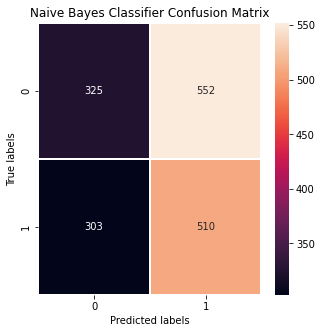

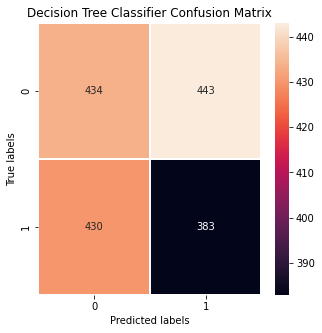

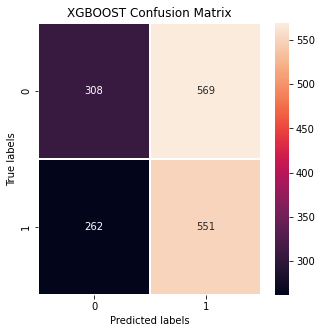

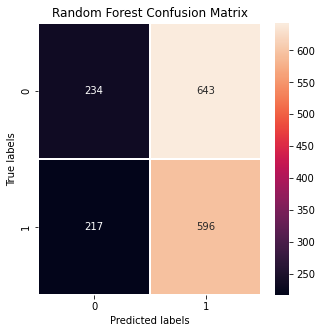

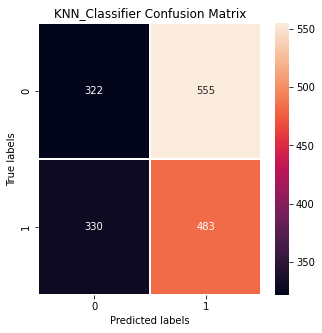

In [ ]:
for i, v in models:
    
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    
    print(f"----------------------------- {i} Model Test Results -----------------------------")
    print(f"\n Model Accuracy:\n {accuracy}\n")
    print(f"\n Classification report:\n\n {classification}")
    confusionMatrix(i, confusion_matrix)

# 6.Clustering Problem

## 6.1 Elbow Method

In [ ]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 10):
 kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
 kmeans.fit(featuresDF)
 wcss.append(kmeans.inertia_)

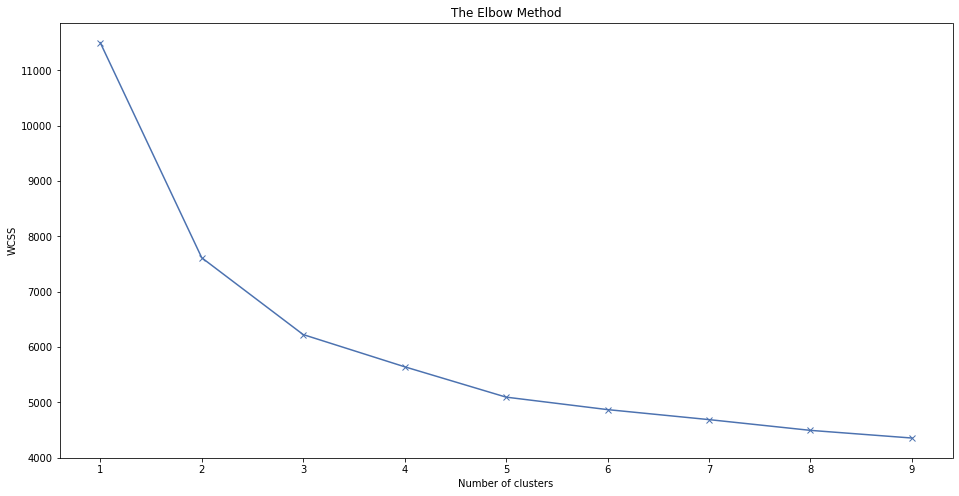

In [ ]:
plt.figure(figsize = (16, 8))
plt.title('The Elbow Method')
plt.plot(range(1, 10), wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

## 6.2 Silhoutte Score

In [ ]:
from sklearn.metrics import silhouette_score 

silhouetteScores = []

for i in range(2, 10):
    km = KMeans(n_clusters = i, random_state = 42)
    c = km.fit_predict(featuresDF)
    silhouetteScores.append(silhouette_score(featuresDF, c))

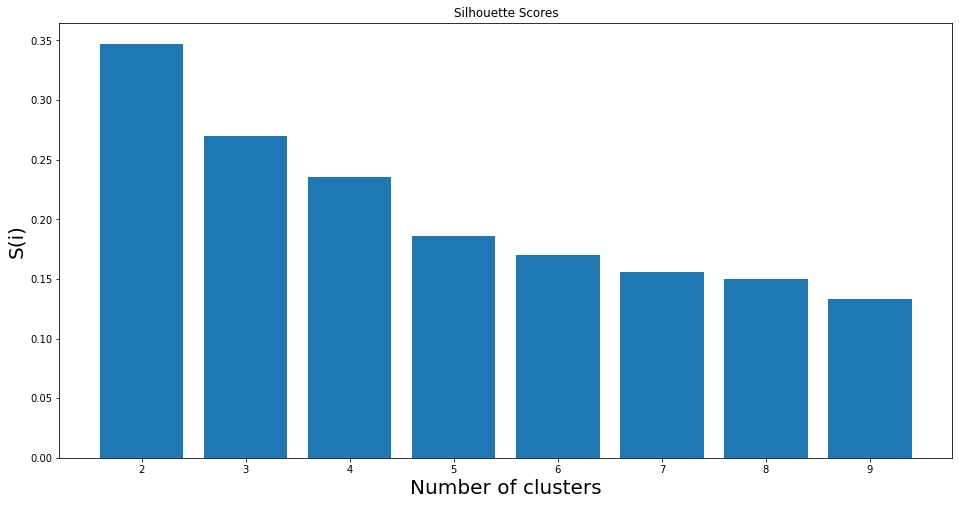

In [ ]:
plt.figure(figsize = (16, 8))
plt.title('Silhouette Scores')
plt.bar(range(2,10), silhouetteScores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

## 6.3 Model Building

In [ ]:
# Training a predicting using K-Means Algorithm.
kmeans = KMeans(n_clusters = 2, random_state = 42).fit(featuresDF)
pred = kmeans.predict(featuresDF)

# Appending those cluster value into main dataframe (without standard-scalar)
featuresDF['cluster'] = pred + 1 # preprocessed data
trainSet['cluster'] = pred + 1 # old data

In [ ]:
featuresDF["cluster"].value_counts()

1    1575
2     537
Name: cluster, dtype: int64

## 6.4 Cluster Interpretation

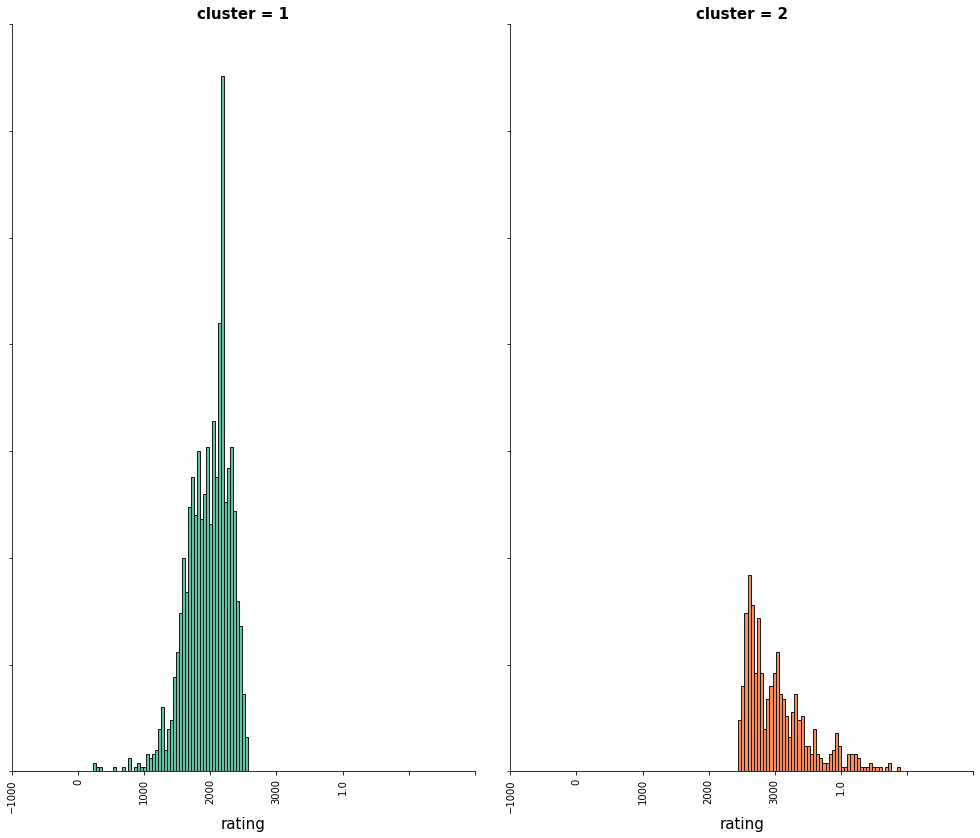

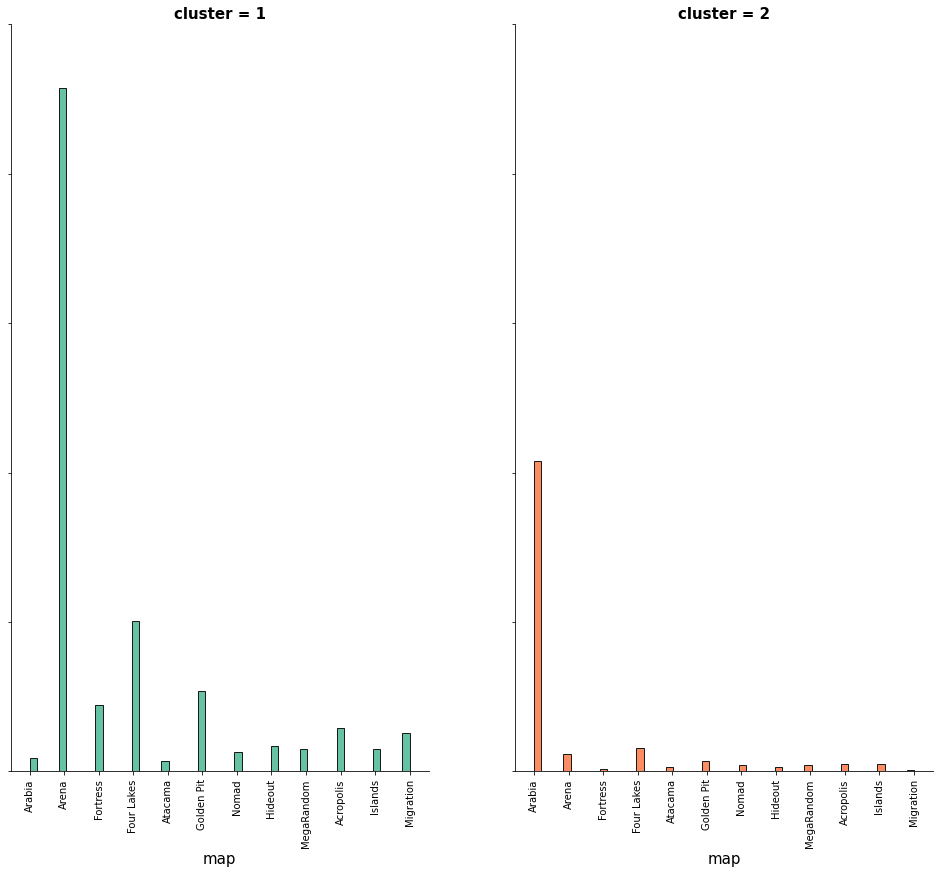

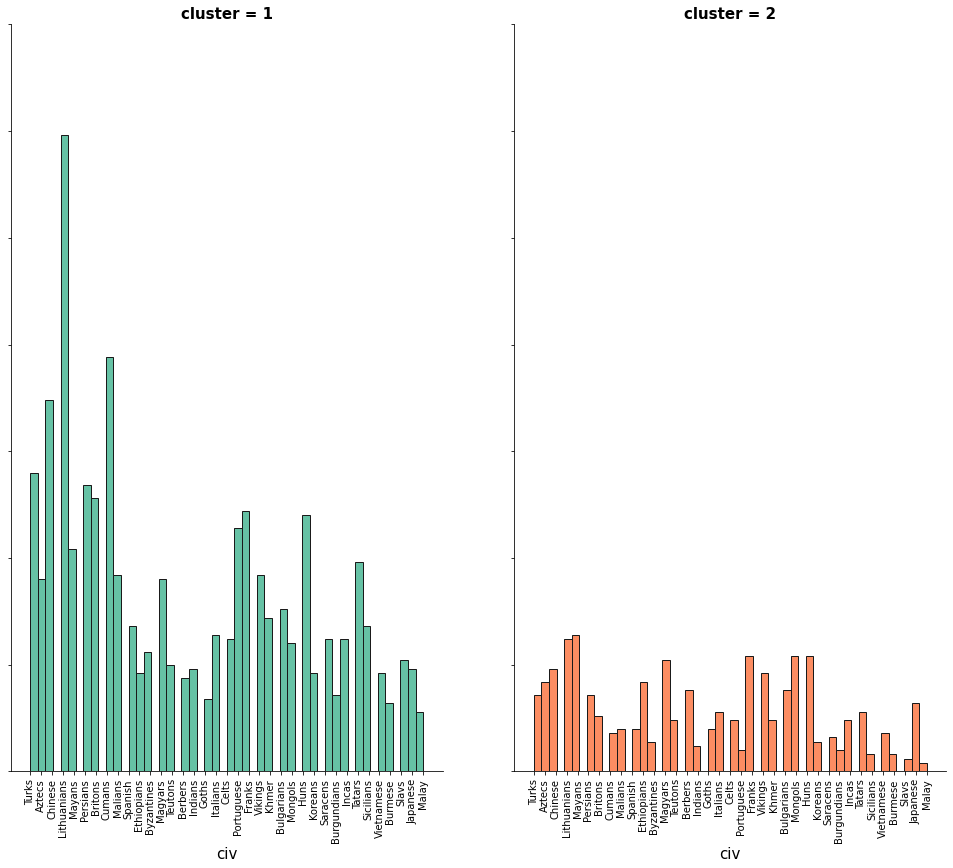

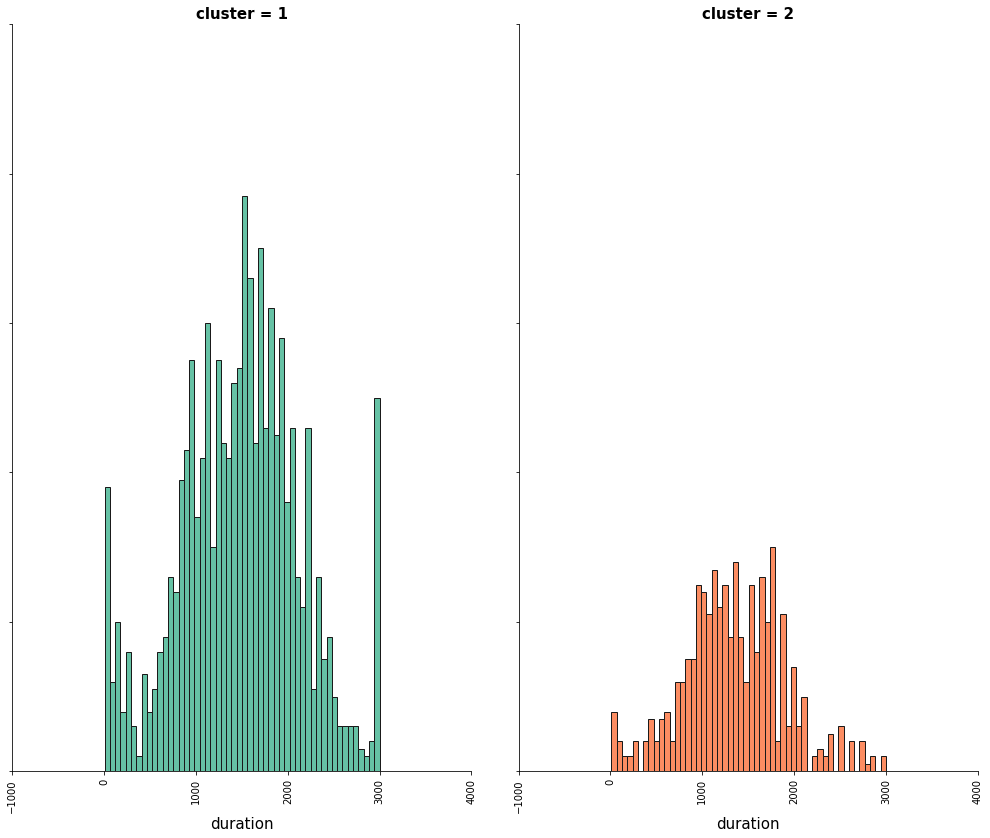

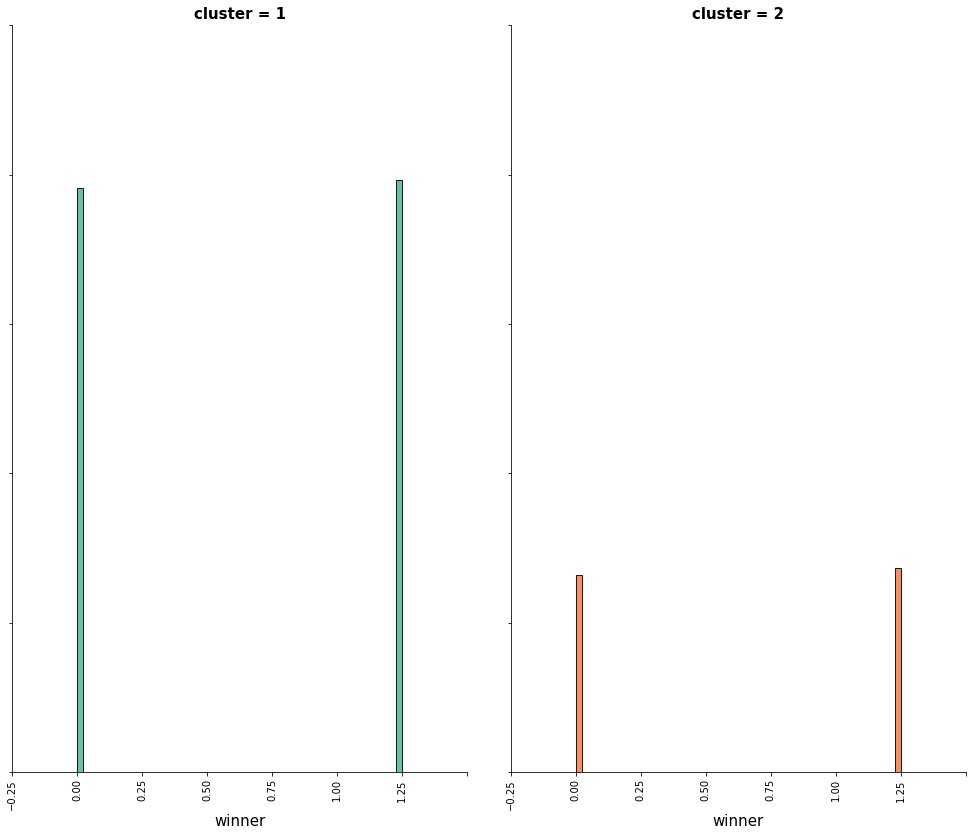

In [ ]:
for i in trainSet:
    if (i == "cluster"):
      continue

    g = sns.FacetGrid(trainSet, col = "cluster", hue = "cluster", palette = "Set2")
    g.map(plt.hist, i, bins = 52, ec = "k") 
    g.set_xticklabels(rotation = 90, color = 'black')
    g.set_yticklabels(color = 'black')
    g.set_xlabels(size = 15, color = 'black')
    g.set_titles(size = 15, color = 'black', fontweight = "bold")
    g.fig.set_figheight(5)
    plt.gcf().set_size_inches(15, 15)

*   Cluster 1 is the low and average rating players. Ranked Match duration of the Cluster 1 players is longer.
*   Cluster 2 is the high rating players. Ranked Match duration of the Cluster 2 players is shorter.